# Image Classification


## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-10-28 23:09:02.357947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preprocessing
### Data download
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), '/Users/alexanderdelriscomorales/Downloads/AI_ML_Files/cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Show some images

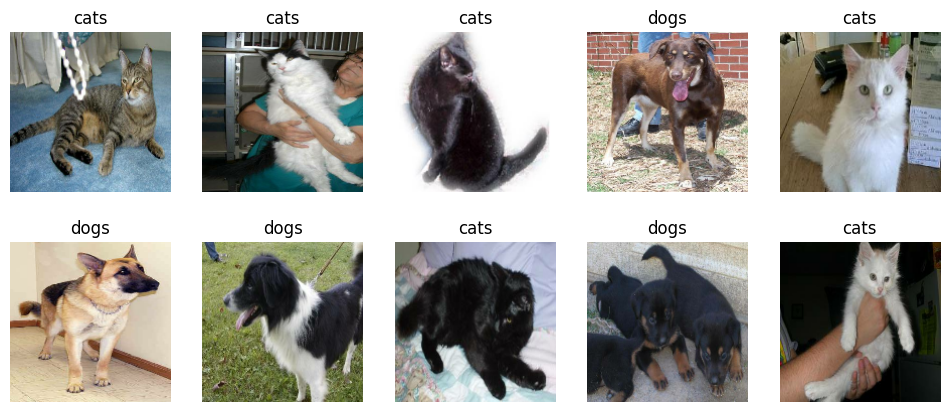

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split the data
As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## A basic Keras model
### VGG-1 model


In [8]:
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# define a model with 1 VGG block
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [9]:
# train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10


63/63 [==============================] - 26s 379ms/step - loss: 0.7863 - accuracy: 0.5070 - val_loss: 0.6913 - val_accuracy: 0.4950
Epoch 2/10
63/63 [==============================] - 24s 372ms/step - loss: 0.6887 - accuracy: 0.5535 - val_loss: 0.6846 - val_accuracy: 0.5433
Epoch 3/10
63/63 [==============================] - 24s 374ms/step - loss: 0.6841 - accuracy: 0.5480 - val_loss: 0.6762 - val_accuracy: 0.5718
Epoch 4/10
63/63 [==============================] - 24s 377ms/step - loss: 0.6718 - accuracy: 0.5925 - val_loss: 0.6686 - val_accuracy: 0.5829
Epoch 5/10
63/63 [==============================] - 24s 380ms/step - loss: 0.6654 - accuracy: 0.5875 - val_loss: 0.6661 - val_accuracy: 0.5817
Epoch 6/10
63/63 [==============================] - 24s 379ms/step - loss: 0.6629 - accuracy: 0.5980 - val_loss: 0.6665 - val_accuracy: 0.5755
Epoch 7/10
63/63 [==============================] - 24s 377ms/step - loss: 0.6507 - accuracy: 0.6200 - val_loss: 0.6646 - val_accuracy: 0.5891
Epoch 8/10

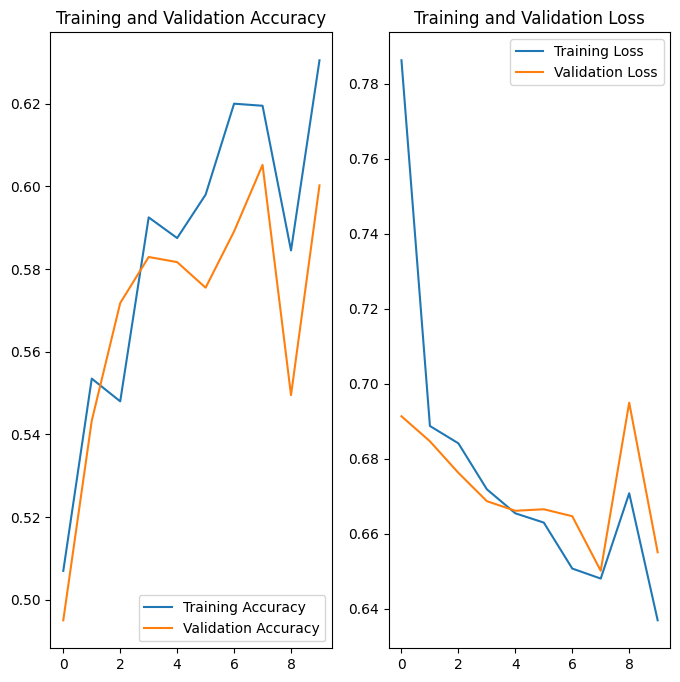

In [10]:
# visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and Validation Accuracy:

Training Accuracy (Blue Line): This line shows a general increase, suggesting that the model is progressively fitting to the training data.
Validation Accuracy (Orange Line): After an initial increase in validation accuracy, there is some fluctuation post epoch 4, and the accuracy dips towards the end. This fluctuation and divergence from training accuracy might be indicative of overfitting.
Training and Validation Loss:

Training Loss (Blue Line): There's a clear decrease in training loss as epochs progress, which is a positive sign.
Validation Loss (Orange Line): The validation loss decreases initially but then rises post epoch 4. This increase, along with the fluctuation in validation accuracy, can be concerning.

### VGG-2 model

In [11]:
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# define a model with 2 VGG blocks
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 30s 462ms/step - loss: 0.7287 - accuracy: 0.5170 - val_loss: 0.6821 - val_accuracy: 0.5681
Epoch 2/10
63/63 [==============================] - 28s 440ms/step - loss: 0.6742 - accuracy: 0.5805 - val_loss: 0.6696 - val_accuracy: 0.5842
Epoch 3/10
63/63 [==============================] - 27s 430ms/step - loss: 0.6624 - accuracy: 0.6005 - val_loss: 0.6772 - val_accuracy: 0.5557
Epoch 4/10
63/63 [==============================] - 27s 423ms/step - loss: 0.6467 - accuracy: 0.6320 - val_loss: 0.6508 - val_accuracy: 0.6052
Epoch 5/10
63/63 [==============================] - 27s 424ms/step - loss: 0.6342 - accuracy: 0.6400 - val_loss: 0.6504 - val_accuracy: 0.5879
Epoch 6/10
63/63 [==============================] - 27s 425ms/step - loss: 0.6084 - accuracy: 0.6800 - val_loss: 0.6249 - val_accuracy: 0.6411
Epoch 7/10
63/63 [==============================] - 27s 428ms/step - loss: 0.5935 - accuracy: 0.6825 - val_loss: 0.6347 - val_accuracy: 0.6312

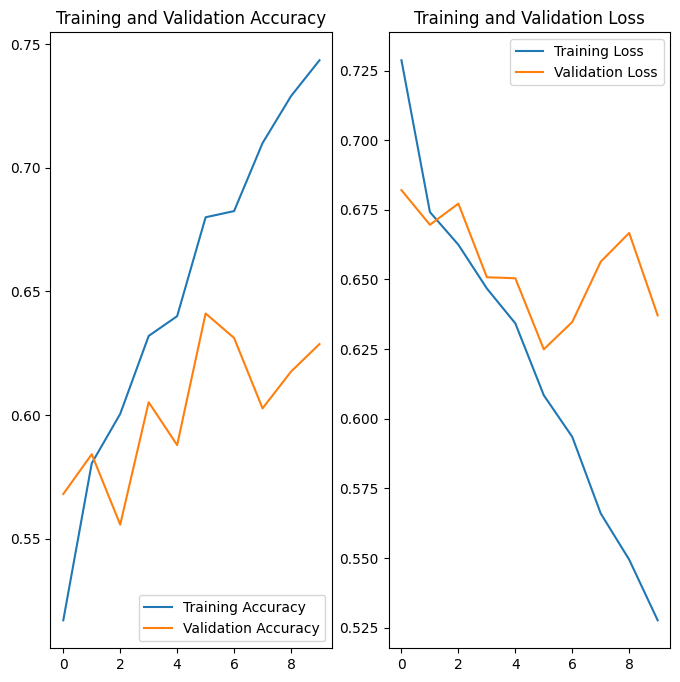

In [12]:
# visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and Validation Accuracy:
Training Accuracy (Blue Line): There's a steady rise in training accuracy as the epochs progress, indicating the model is learning and fitting well to the training data.
Validation Accuracy (Orange Line): The validation accuracy initially increases but starts to fluctuate and diverge from the training accuracy after epoch 4. This suggests potential overfitting, as the model performs well on the training set but not as consistently on the validation set.
Training and Validation Loss:
Training Loss (Blue Line): As expected, the training loss decreases over time, suggesting an improvement in the model's performance on the training data.
Validation Loss (Orange Line): The validation loss seems to decrease until around epoch 4, after which it increases, indicating deteriorating performance on the validation set.

### VGG-3 model

In [13]:
from keras.api._v2.keras import metrics
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers

# define a model with 3 VGG block3
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 30s 460ms/step - loss: 0.7179 - accuracy: 0.5285 - val_loss: 0.6719 - val_accuracy: 0.5780
Epoch 2/10
63/63 [==============================] - 29s 454ms/step - loss: 0.6652 - accuracy: 0.5840 - val_loss: 0.6571 - val_accuracy: 0.5817
Epoch 3/10
63/63 [==============================] - 29s 452ms/step - loss: 0.6451 - accuracy: 0.6465 - val_loss: 0.6451 - val_accuracy: 0.6139
Epoch 4/10
63/63 [==============================] - 29s 452ms/step - loss: 0.6428 - accuracy: 0.6170 - val_loss: 0.6395 - val_accuracy: 0.6300
Epoch 5/10
63/63 [==============================] - 29s 459ms/step - loss: 0.6115 - accuracy: 0.6750 - val_loss: 0.6310 - val_accuracy: 0.6361
Epoch 6/10
63/63 [==============================] - 29s 451ms/step - loss: 0.6036 - accuracy: 0.6755 - val_loss: 0.6162 - val_accuracy: 0.6473
Epoch 7/10
63/63 [==============================] - 29s 451ms/step - loss: 0.5804 - accuracy: 0.7000 - val_loss: 0.6643 - val_accuracy: 0.5941

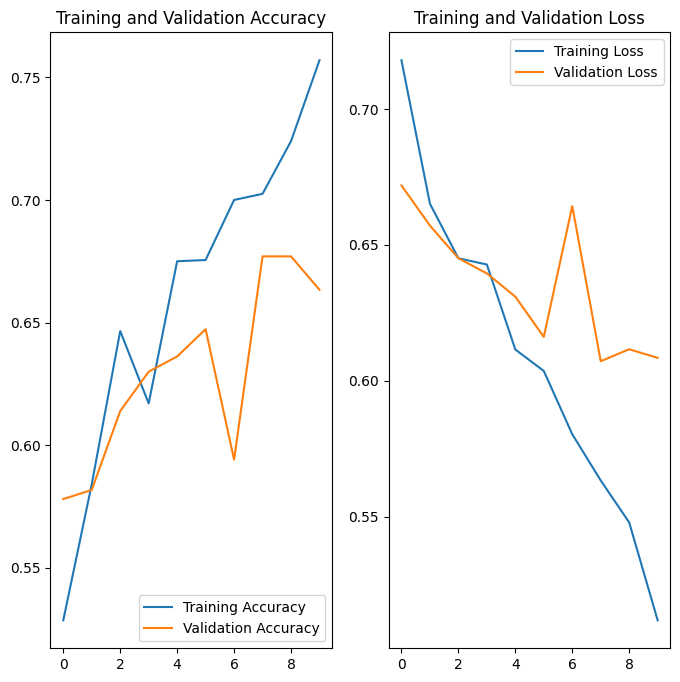

In [14]:
# visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and Validation Accuracy:

Training Accuracy (Blue Line): This line represents how well the model is performing on the training dataset. It starts at a lower accuracy and improves as epochs progress.
Validation Accuracy (Orange Line): This line represents how well the model performs on a separate validation dataset that it hasn't seen during training. It's used to gauge the model's generalization capability.
The gap between the training accuracy and validation accuracy indicates some level of overfitting, as the model performs significantly better on the training data compared to the validation data. Overfitting occurs when the model learns the training data's specific characteristics too well, at the expense of its generalization capability.
Training and Validation Loss:

Training Loss (Blue Line): This line indicates the error or loss the model encounters on the training dataset. A decrease in training loss over epochs means the model is learning.
Validation Loss (Orange Line): This line indicates the loss on the validation dataset. This metric provides insights into how well the model might perform on unseen data.
The loss plots also show signs of overfitting. Around epoch 4 or 5, the validation loss starts to increase, even though the training loss continues to decrease. This divergence suggests that the model is becoming too specific to the training data and not generalizing well.

### Model improvements
- Data augmentation
- Dropouts

In [15]:
# data augmentation
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

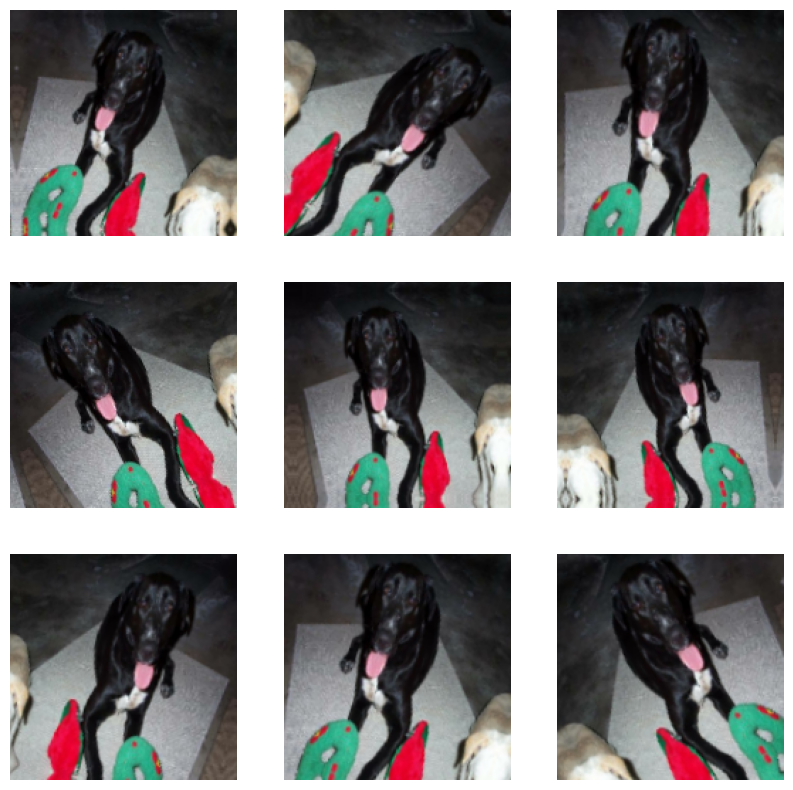

In [16]:
# show some images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
# define a model with 1 VGG block
model = Sequential([
  data_augmentation,
  layers.Rescaling (1./255),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 80, 80, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        9248      
                                                      

In [18]:
# train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 37s 555ms/step - loss: 0.8198 - accuracy: 0.4925 - val_loss: 0.6908 - val_accuracy: 0.5557
Epoch 2/10
63/63 [==============================] - 35s 546ms/step - loss: 0.6940 - accuracy: 0.5230 - val_loss: 0.6888 - val_accuracy: 0.5569
Epoch 3/10
63/63 [==============================] - 35s 547ms/step - loss: 0.6885 - accuracy: 0.5440 - val_loss: 0.6885 - val_accuracy: 0.5693
Epoch 4/10
63/63 [==============================] - 35s 547ms/step - loss: 0.6860 - accuracy: 0.5475 - val_loss: 0.6868 - val_accuracy: 0.5792
Epoch 5/10
63/63 [==============================] - 35s 549ms/step - loss: 0.6809 - accuracy: 0.5655 - val_loss: 0.6832 - val_accuracy: 0.5705
Epoch 6/10
63/63 [==============================] - 35s 546ms/step - loss: 0.6809 - accuracy: 0.5750 - val_loss: 0.6841 - val_accuracy: 0.5594
Epoch 7/10
63/63 [==============================] - 35s 547ms/step - loss: 0.6745 - accuracy: 0.5705 - val_loss: 0.6781 - val_accuracy: 0.5916

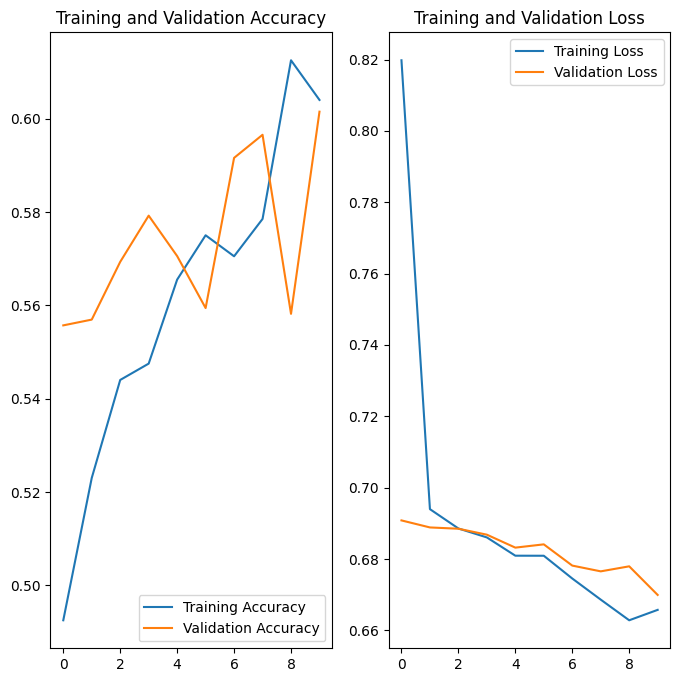

In [19]:
# visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and Validation Accuracy:

Training Accuracy (Blue Line): The model's accuracy on the training dataset steadily increases as the epochs progress.
Validation Accuracy (Orange Line): The validation accuracy experiences more fluctuation, and towards the later epochs, it diverges from the training accuracy, indicating some overfitting.
A noticeable observation is that while the training accuracy improves, the validation accuracy experiences more fluctuations and doesn't show a clear improving trend, particularly after epoch 4.

Training and Validation Loss:

Training Loss (Blue Line): The training loss decreases quickly in the first epoch and then gradually over the next epochs. This suggests the model is learning and improving its performance on the training data.
Validation Loss (Orange Line): The validation loss starts relatively high but then decreases and stabilizes. There's a slight upward trend from epoch 6 onwards.
There is an apparent gap between training and validation loss, especially in the initial epochs, which indicates a difference in model performance between the training and validation datasets.

## Transfer Learning with MobileNet V2
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


#### Rescale pixel values
MobileNetV2 model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note:** Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.

  rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

**Note:** If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], or use the included preprocess_input function.

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [22]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
# freeze the CNN base
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**Apply a tf.keras.layers.Dense layer** to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [26]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Build a model** by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

### Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model
After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 11s 323ms/step - loss: 0.8732 - accuracy: 0.4072


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.41


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 36s 508ms/step - loss: 0.7216 - accuracy: 0.5710 - val_loss: 0.5788 - val_accuracy: 0.6993
Epoch 2/10
63/63 [==============================] - 32s 509ms/step - loss: 0.5189 - accuracy: 0.7400 - val_loss: 0.4114 - val_accuracy: 0.8614
Epoch 3/10
63/63 [==============================] - 33s 522ms/step - loss: 0.3960 - accuracy: 0.8475 - val_loss: 0.3156 - val_accuracy: 0.9158
Epoch 4/10
63/63 [==============================] - 32s 504ms/step - loss: 0.3221 - accuracy: 0.8895 - val_loss: 0.2564 - val_accuracy: 0.9344
Epoch 5/10
63/63 [==============================] - 32s 508ms/step - loss: 0.2801 - accuracy: 0.9000 - val_loss: 0.2177 - val_accuracy: 0.9443
Epoch 6/10
63/63 [==============================] - 32s 506ms/step - loss: 0.2461 - accuracy: 0.9155 - val_loss: 0.1855 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 33s 514ms/step - loss: 0.2281 - accuracy: 0.9190 - val_loss: 0.1654 - val_accuracy: 0.9604
Epoch 8/10

### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

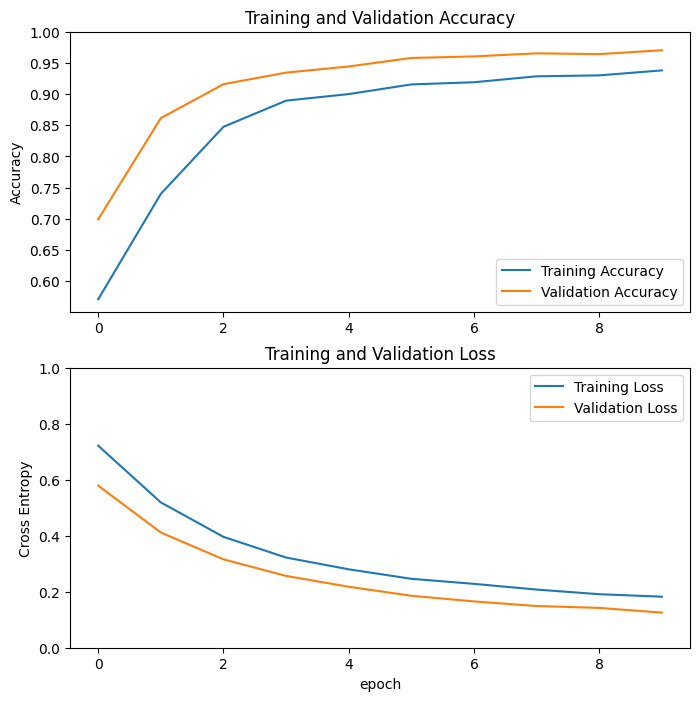

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Note:** If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.
To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Fine tuning



In [33]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

# continue traininig
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  154
Epoch 10/20


63/63 [==============================] - 49s 684ms/step - loss: 0.1300 - accuracy: 0.9475 - val_loss: 0.0544 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 42s 665ms/step - loss: 0.0922 - accuracy: 0.9625 - val_loss: 0.0459 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 42s 663ms/step - loss: 0.0635 - accuracy: 0.9740 - val_loss: 0.0453 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 42s 666ms/step - loss: 0.0662 - accuracy: 0.9725 - val_loss: 0.0334 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 45s 710ms/step - loss: 0.0579 - accuracy: 0.9740 - val_loss: 0.0414 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 42s 664ms/step - loss: 0.0573 - accuracy: 0.9775 - val_loss: 0.0458 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 42s 661ms/step - loss: 0.0502 - accuracy: 0.9805 - val_loss: 0.0539 - val_accuracy: 0.9814
Epoc

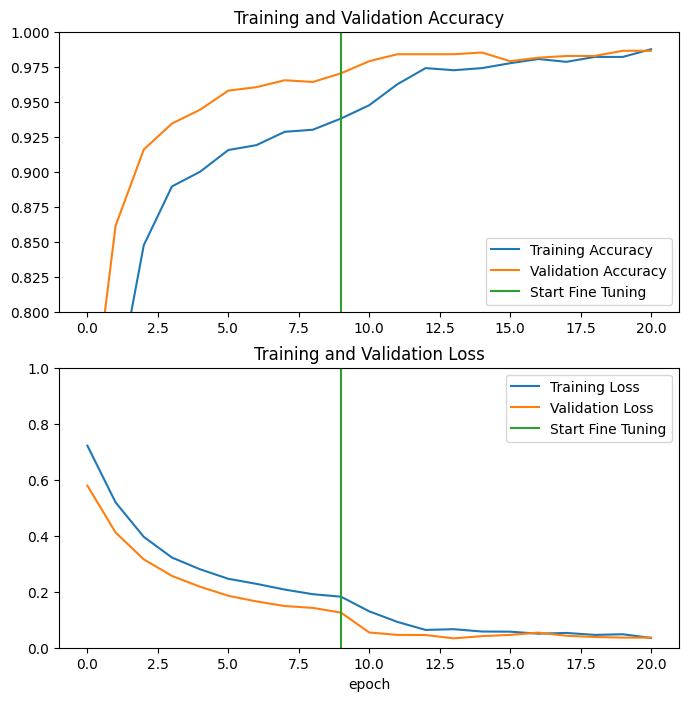

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction
Finally you can verify the performance of the model on new data using test set.

6/6 [==============================] - 2s 344ms/step - loss: 0.0146 - accuracy: 1.0000
Test accuracy : 1.0
Predictions:
 [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1]
Labels:
 [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1]


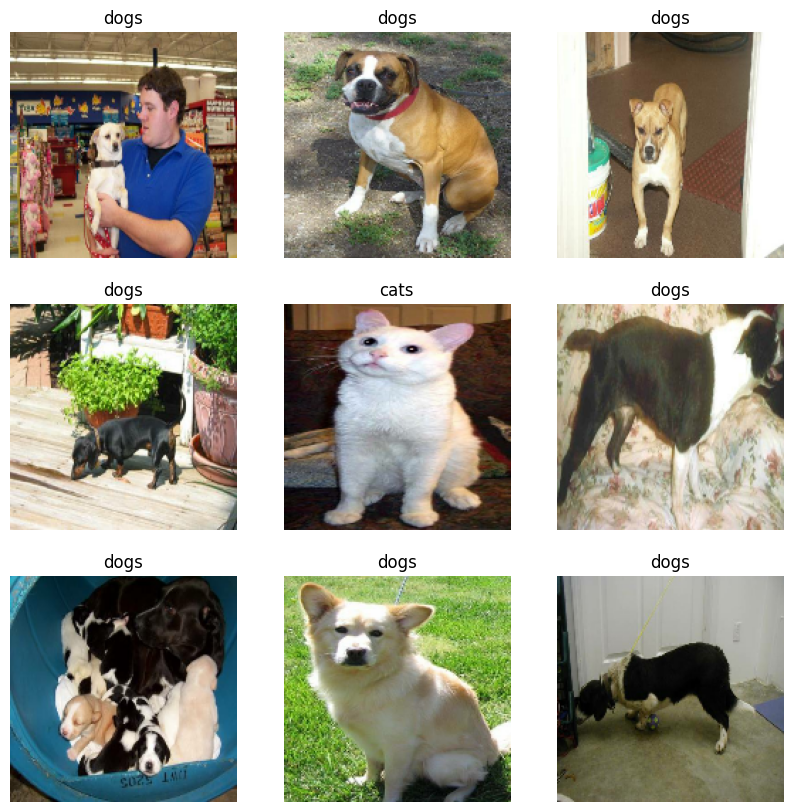

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Save and load model
```
# This is formatted as code

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(3,)),
    tf.keras.layers.Softmax()])
model.save("model.keras")
loaded_model = tf.keras.models.load_model("model.keras")
x = tf.random.uniform((10, 3))
assert np.allclose(model.predict(x), loaded_model.predict(x))
```

The SavedModel or HDF5 file contains:
- The model's configuration (architecture)
- The model's weights
- The model's optimizer's state (if any)

Thus models can be reinstantiated in the exact same state, without any of the code used for model definition or training.


## Summary
- Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.